In [2059]:
# XGboost: hyperparameters
# scale_pos_weight: unbalance dataset . value = sum(negative cases)/ sum(postive case)
# eval_metric: Use AUC for false postive, error for accuracy etc

# 0. Problem statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.

In this competition, your goal is *to build a machine learning model that is able to predict churning customers based on the features provided for their usage.*

**Customer behaviour during churn:**

Customers usually do not decide to switch to another competitor instantly, but rather over a
period of time (this is especially applicable to high-value customers). In churn prediction, we
assume that there are three phases of customer lifecycle :

1. <u>The ‘good’ phase:</u> In this phase, the customer is happy with the service and behaves as usual.

2. <u>The ‘action’ phase:</u> The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. It is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

3. <u>The ‘churn’ phase:</u> In this phase, the customer is said to have churned. In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month (September) is the ‘churn’ phase.

# 1. Loading dependencies & datasets

In [2196]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer


from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC


from sklearn.metrics import confusion_matrix, accuracy_score,precision_score,recall_score,f1_score,classification_report 
# from sklearn.pipeline import 
from imblearn.pipeline import Pipeline



from imblearn.over_sampling import SMOTE

from sklearn.feature_selection import RFE


import re
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

Next, we load our datasets and the data dictionary file.

The train.csv file contains both dependent and independent features, while the test.csv contains only the independent variables.

So, for model selection, I will create our own train/test dataset from the train.csv and use the model to predict the solution using the features in unseen test.csv data for submission.

In [2061]:
# data = pd.read_csv("train.csv")
# unseen = pd.read_csv("test.csv")
# sample = pd.read_csv("sample.csv")
# data_dict = pd.read_csv("data_dictionary.csv")

# print(data.shape)
# print(unseen.shape)
# print(sample.shape)
# print(data_dict.shape)

1. Lets analyze the data dictionary versus the churn dataset.
2. The data dictonary contains a list of abbrevations which provide you all the information you need to understand what a specific feature/variable in the churn dataset represents
3. Example: 

> "arpu_7" -> Average revenue per user + KPI for the month of July
>
> "onnet_mou_6" ->  All kind of calls within the same operator network + Minutes of usage voice calls + KPI for the month of June
>
>"night_pck_user_8" -> Scheme to use during specific night hours only + Prepaid service schemes called PACKS + KPI for the month of August
>
>"max_rech_data_7" -> Maximum + Recharge + Mobile internet + KPI for the month of July

Its important to understand the definitions of each feature that you are working with, take notes on which feature you think might impact the churn rate of a user, and what sort of analysis could you do to understand the distribution of the feature better.

In [2062]:
data =pd.read_csv('./kaggle/input/train.csv')
data.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,...,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,...,0,0,NaN,1.0,NaN,710,0.0,0.0,0.0,0
2,2,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,60.806,103.176,...,0,0,NaN,NaN,NaN,882,0.0,0.0,0.0,0
3,3,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,156.362,205.260,...,0,0,NaN,NaN,NaN,982,0.0,0.0,0.0,0
4,4,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,240.708,128.191,...,1,0,1.0,1.0,1.0,647,0.0,0.0,0.0,0


In [2063]:
#__________________________________________________________________#InitialCheck

In [2064]:
#initial check
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Columns: 172 entries, id to churn_probability
dtypes: float64(135), int64(28), object(9)
memory usage: 91.9+ MB


In [2065]:
data.describe()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
count,69999.000000,69999.0,69297.0,69297.0,69297.0,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,...,69999.000000,69999.000000,17568.000000,17865.000000,18417.000000,69999.000000,69999.000000,69999.000000,69999.00000,69999.000000
mean,34999.000000,109.0,0.0,0.0,0.0,283.134365,278.185912,278.858826,133.153275,133.894438,...,0.081444,0.085487,0.916325,0.909544,0.890319,1220.639709,68.108597,65.935830,60.07674,0.101887
std,20207.115084,0.0,0.0,0.0,0.0,334.213918,344.366927,351.924315,299.963093,311.277193,...,0.634547,0.680035,0.276907,0.286842,0.312501,952.426321,269.328659,267.899034,257.22681,0.302502
min,0.000000,109.0,0.0,0.0,0.0,-2258.709000,-1289.715000,-945.808000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000,0.000000,0.00000,0.000000
25%,17499.500000,109.0,0.0,0.0,0.0,93.581000,86.714000,84.095000,7.410000,6.675000,...,0.000000,0.000000,1.000000,1.000000,1.000000,468.000000,0.000000,0.000000,0.00000,0.000000
50%,34999.000000,109.0,0.0,0.0,0.0,197.484000,191.588000,192.234000,34.110000,32.280000,...,0.000000,0.000000,1.000000,1.000000,1.000000,868.000000,0.000000,0.000000,0.00000,0.000000
75%,52498.500000,109.0,0.0,0.0,0.0,370.791000,365.369500,369.909000,119.390000,115.837500,...,0.000000,0.000000,1.000000,1.000000,1.000000,1813.000000,0.000000,0.000000,0.00000,0.000000
max,69998.000000,109.0,0.0,0.0,0.0,27731.088000,35145.834000,33543.624000,7376.710000,8157.780000,...,33.000000,41.000000,1.000000,1.000000,1.000000,4337.000000,12916.220000,9165.600000,11166.21000,1.000000


In [2066]:
# create original Copy of data
data_org  = data.copy()

In [2067]:
ids = ['id','circle_id']
recharge_date = [i for i in list(data.columns) if re.search('date_of_last_rech',i)] 
total_amounts = [i for i in list(data.columns) if re.search('total.+amt',i)]
total_outgoing_minutes = [i for i in list(data.columns) if re.search('total.+og.+mou',i)]
total_incoming_minutes = [i for i in list(data.columns) if re.search('total.+ic.+mou',i)]
offnetwork_minutes = [i for i in list(data.columns) if re.search('offnet',i)]
average_revenue_3g = [i for i in list(data.columns) if re.search('arpu.+3g',i)]
average_revenue_2g = [i for i in list(data.columns) if re.search('arpu.+2g',i)]
volume_3g = [i for i in list(data.columns) if re.search('vol.+3g',i)]
volume_2g = [i for i in list(data.columns) if re.search('vol.+2g',i)]
age_on_network = [i for i in list(data.columns) if re.search('aon',i)]
average_revenue_per_user = [i for i in list(data.columns) if re.search('arpu_[6,7,8]',i)]
max_amounts = [i for i in list(data.columns) if re.search('max_rech_amt_',i)]
total_amounts_data = [i for i in list(data.columns) if re.search('total_rech_data_[6,7,8]',i)]
max_amounts_data = [i for i in list(data.columns) if re.search('max_rech_data_[6,7,8]',i)]
average_amount_data = [i for i in list(data.columns) if re.search('av_rech_amt_data_[6,7,8]',i)]
night_pck_user = [i for i in list(data.columns) if re.search('night_pck_user_[6,7,8]',i)]
fb_user = [i for i in list(data.columns) if re.search('fb_user_[6,7,8]',i)]
vbc = [ 'jun_vbc_3g', 'jul_vbc_3g','aug_vbc_3g', ]

std_outgoing_minutes = [i for i in list(data.columns) if re.search('std_og_mou.+',i)]
std_incoming_minutes = [i for i in list(data.columns) if re.search('std_ic_mou.+',i)]

isd_outgoing_minutes = [i for i in list(data.columns) if re.search('isd_og_mou.+',i)]
isd_incoming_minutes = [i for i in list(data.columns) if re.search('isd_ic_mou.+',i)]

loc_outgoing_minutes = [i for i in list(data.columns) if re.search('loc_og_mou.+',i)]
loc_incoming_minutes = [i for i in list(data.columns) if re.search('loc_ic_mou.+',i)]

roam_outgoing_minutes = [i for i in list(data.columns) if re.search('roam_og_mou.+',i)]
roam_incoming_minutes = [i for i in list(data.columns) if re.search('roam_ic_mou.+',i)]


spl_outgoing_minutes = [i for i in list(data.columns) if re.search('spl_og_mou.+',i)]
spl_incoming_minutes = [i for i in list(data.columns) if re.search('spl_ic_mou.+',i)]

other_outgoing_minutes = [i for i in list(data.columns) if re.search('og_others.+',i)]
other_incoming_minutes = [i for i in list(data.columns) if re.search('ic_others.+',i)]

count_of_recharge_3g = [i for i in list(data.columns) if re.search('count_rech_3g+',i)]
count_of_recharge_2g = [i for i in list(data.columns) if re.search('count_rech_2g.+',i)]

total_recharge_number = [i for i in list(data.columns) if re.search('total_rech_num.+',i)]



#Storing them in a single flat list
variables = [*ids, 
             *total_amounts, 
             *max_amounts,
             *total_outgoing_minutes, 
             *total_incoming_minutes,
             *offnetwork_minutes, 
             *average_revenue_3g, 
             *average_revenue_2g,
             *volume_3g,
             *volume_2g,
             *age_on_network, 
             *average_revenue_per_user,
             *total_amounts_data,
             *max_amounts_data,
             *average_amount_data,
             *night_pck_user,
             *fb_user,
             *vbc,
             *std_outgoing_minutes,
             *std_incoming_minutes,
             *isd_outgoing_minutes,
             *isd_incoming_minutes,
             *loc_outgoing_minutes,
             *loc_incoming_minutes,
             *roam_outgoing_minutes,
             *roam_incoming_minutes,
             *spl_outgoing_minutes,
             *spl_incoming_minutes,
             *other_outgoing_minutes,
             *other_incoming_minutes,
             *count_of_recharge_3g,
             *count_of_recharge_2g,
             *total_recharge_number,
             'churn_probability']

# data = data[variables].set_index('id')
len(variables)
# Dropped the column like t2f, t2c, onnet, offnet etc instead using aggregate column

97

In [2068]:
def days_since_last_recharge(data):
    recharge_date_columns = [
        'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8'
    ]
    
    
    for col in recharge_date_columns:
        data[col] = pd.to_datetime(data[col], format='%m/%d/%Y', errors='coerce')
        
    data['last_recharge_date'] = data[recharge_date_columns].max(axis=1)
    
    # Get the last data recharge date by taking the maximum date across specified columns
    
    
    # Determine the maximum date for comparison
    max_recharge_date = data[recharge_date_columns].max().max()
    
    
    # Calculate days since last recharge and last data recharge, handle NaT values
    data['days_since_last_recharge'] = (max_recharge_date - data['last_recharge_date']).dt.days
    
    
    # Assign -100 where no recharge or data recharge was done (i.e., if date is NaT)
    data['days_since_last_recharge'].fillna(-100, inplace=True)

    return data


In [2069]:
data = days_since_last_recharge(data)

In [2070]:
variables.append('days_since_last_recharge')


In [2071]:
data = data[variables].set_index('id')

In [2072]:
variables.remove('id')

In [2073]:
data[['days_since_last_recharge']].isna().mean()*100

days_since_last_recharge    0.0
dtype: float64

# 2. Create X, y and then Train test split

Lets create X and y datasets and skip "circle_id" since it has only 1 unique value

In [2077]:
unique_vals_ls_4 = []
for col in variables:
    uv = data[col].nunique()
    if uv < 2:
        unique_vals_ls_4.append((col))
len(unique_vals_ls_4)

1

In [2078]:
unique_vals_ls_4

['circle_id']

In [2079]:
data = data.drop('circle_id', axis=1)

In [2080]:
#---------------------------------------------------------------filter HighValue Customer


In [2081]:
def filter_high_value_customer(data):
    data['AVG_amt_6_7'] = data[['total_rech_amt_6', 'total_rech_amt_7']].mean(axis=1)
    data = data[data['AVG_amt_6_7'] > data['AVG_amt_6_7'].quantile(.5)]
    data = data.drop('AVG_amt_6_7', axis = 1)
    return data

data = filter_high_value_customer(data)

In [2082]:
y = data.pop('churn_probability')
X = data
print(X.shape, y.shape)

(34979, 95) (34979,)


In [2083]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((27983, 95), (6996, 95), (27983,), (6996,))

In [2084]:
X_train.describe()

,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_ic_mou_6,...,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,days_since_last_recharge
count,27983.000000,27983.000000,27983.000000,27983.000000,27983.000000,27983.000000,27983.000000,27983.000000,27983.000000,27983.000000,...,9486.000000,9618.000000,9518.000000,9486.000000,9618.000000,9518.000000,27983.000000,27983.000000,27983.000000,27983.000000
mean,537.393132,532.014830,483.167387,147.084480,149.183111,140.053711,513.471422,528.902703,478.824130,263.071617,...,0.714738,0.752235,0.723892,1.764284,1.954356,1.927926,10.353679,10.310367,8.968945,5.570275
std,494.493285,506.218948,550.537228,146.117698,147.748499,143.251111,568.867014,590.359085,593.092666,329.482871,...,1.427203,1.614075,1.673596,2.609074,2.866532,2.708696,8.282998,8.487457,8.477689,8.297566
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,290.000000,286.000000,217.000000,90.000000,67.500000,50.000000,164.625000,169.470000,116.390000,71.010000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,5.000000,4.000000,1.000000
50%,436.000000,428.000000,390.000000,110.000000,120.000000,130.000000,345.980000,353.480000,303.930000,169.660000,...,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,8.000000,8.000000,7.000000,3.000000
75%,656.000000,653.000000,630.000000,154.000000,154.000000,154.000000,659.175000,685.500000,626.530000,334.205000,...,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,13.000000,13.000000,12.000000,6.000000
max,35190.000000,40335.000000,45320.000000,3559.000000,3299.000000,3399.000000,10674.030000,8285.640000,14043.060000,7716.140000,...,29.000000,34.000000,45.000000,42.000000,48.000000,34.000000,125.000000,138.000000,127.000000,85.000000


# 3. Handling Missing data

First lets analyse the missing data. We can use missingno library for quick visualizations.

In [2085]:
len(data.columns)

95

In [2086]:
# missing data and Uniquer value

missing_per = data.isna().mean()*100
missing_per

total_rech_amt_6             0.000000
total_rech_amt_7             0.000000
total_rech_amt_8             0.000000
max_rech_amt_6               0.000000
max_rech_amt_7               0.000000
                              ...    
count_rech_2g_8             65.765173
total_rech_num_6             0.000000
total_rech_num_7             0.000000
total_rech_num_8             0.000000
days_since_last_recharge     0.000000
Length: 95, dtype: float64

In [2087]:
new_vars = missing_per[missing_per.le(40)].index
new_vars

Index(['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8', 'total_og_mou_6',
       'total_og_mou_7', 'total_og_mou_8', 'total_ic_mou_6', 'total_ic_mou_7',
       'total_ic_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8',
       'vol_3g_mb_6', 'vol_3g_mb_7', 'vol_3g_mb_8', 'vol_2g_mb_6',
       'vol_2g_mb_7', 'vol_2g_mb_8', 'aon', 'arpu_6', 'arpu_7', 'arpu_8',
       'jun_vbc_3g', 'jul_vbc_3g', 'aug_vbc_3g', 'std_og_mou_6',
       'std_og_mou_7', 'std_og_mou_8', 'std_ic_mou_6', 'std_ic_mou_7',
       'std_ic_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8',
       'isd_ic_mou_6', 'isd_ic_mou_7', 'isd_ic_mou_8', 'loc_og_mou_6',
       'loc_og_mou_7', 'loc_og_mou_8', 'loc_ic_mou_6', 'loc_ic_mou_7',
       'loc_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8',
       'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'spl_og_mou_6',
       'spl_og_mou_7', 'spl_og_mou_8', 'spl_ic_mou_6', 'spl_ic_m

In [2088]:
data = data[new_vars]

In [2089]:
len(new_vars)

68

In [2090]:
X_train_filtered = X_train[new_vars]

In [2091]:
missing_data_percent = X_train_filtered.isnull().any()
impute_cols = missing_data_percent[missing_data_percent.gt(0)].index
impute_cols

Index(['offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'std_og_mou_6',
       'std_og_mou_7', 'std_og_mou_8', 'std_ic_mou_6', 'std_ic_mou_7',
       'std_ic_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8',
       'isd_ic_mou_6', 'isd_ic_mou_7', 'isd_ic_mou_8', 'loc_og_mou_6',
       'loc_og_mou_7', 'loc_og_mou_8', 'loc_ic_mou_6', 'loc_ic_mou_7',
       'loc_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8',
       'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'spl_og_mou_6',
       'spl_og_mou_7', 'spl_og_mou_8', 'spl_ic_mou_6', 'spl_ic_mou_7',
       'spl_ic_mou_8', 'og_others_6', 'og_others_7', 'og_others_8',
       'ic_others_6', 'ic_others_7', 'ic_others_8'],
      dtype='object')

In [2092]:
# print(new_vars)

In [2093]:
imp = SimpleImputer(strategy='constant', fill_value=0)
X_train_filtered[impute_cols] = imp.fit_transform(X_train_filtered[impute_cols])

In [2094]:
X_train_filtered.isna().any().sum()

np.int64(0)

# 4. Exploratory Data Analysis & Preprocessing

Lets start by analysing the univariate distributions of each feature.

<Axes: >

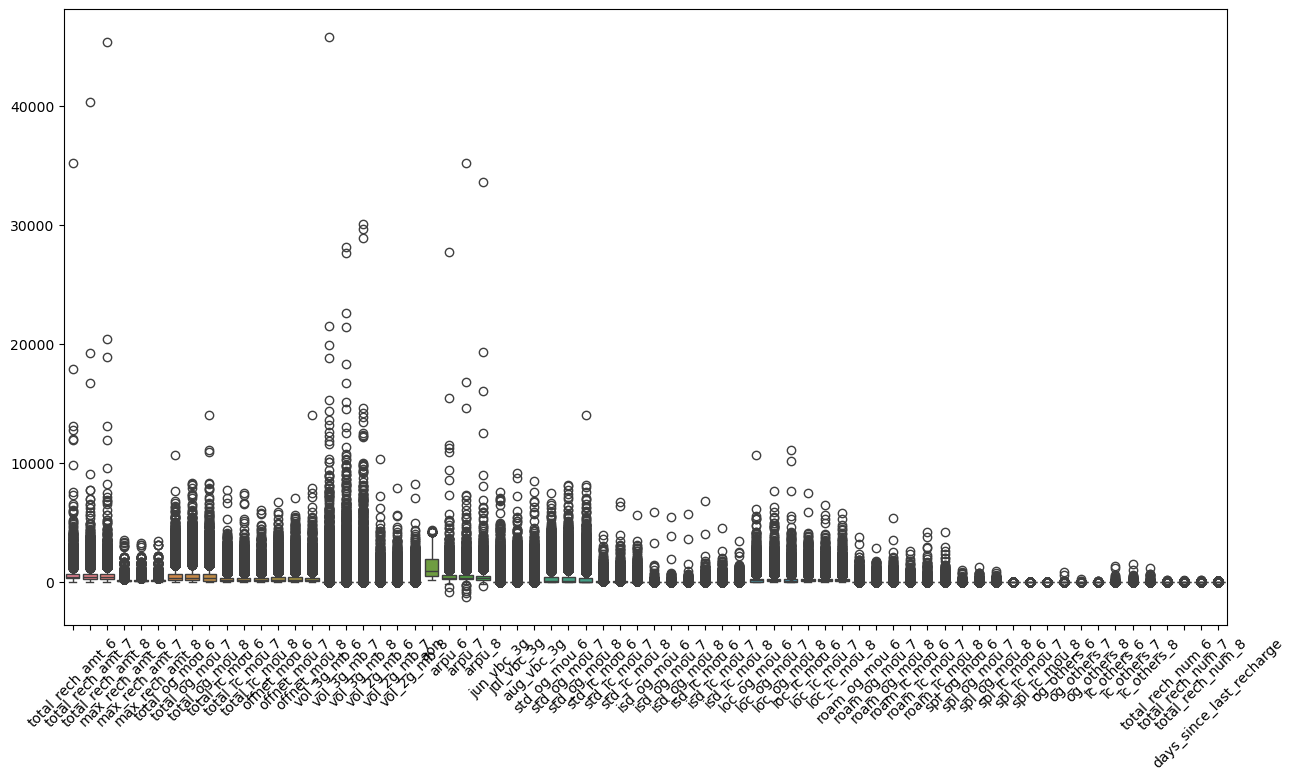

In [2095]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = X_train_filtered)

### 4.1 Handling outliers

The box plots of these features show there a lot of outliers. These can be capped with k-sigma method.

In [2096]:
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

<Axes: >

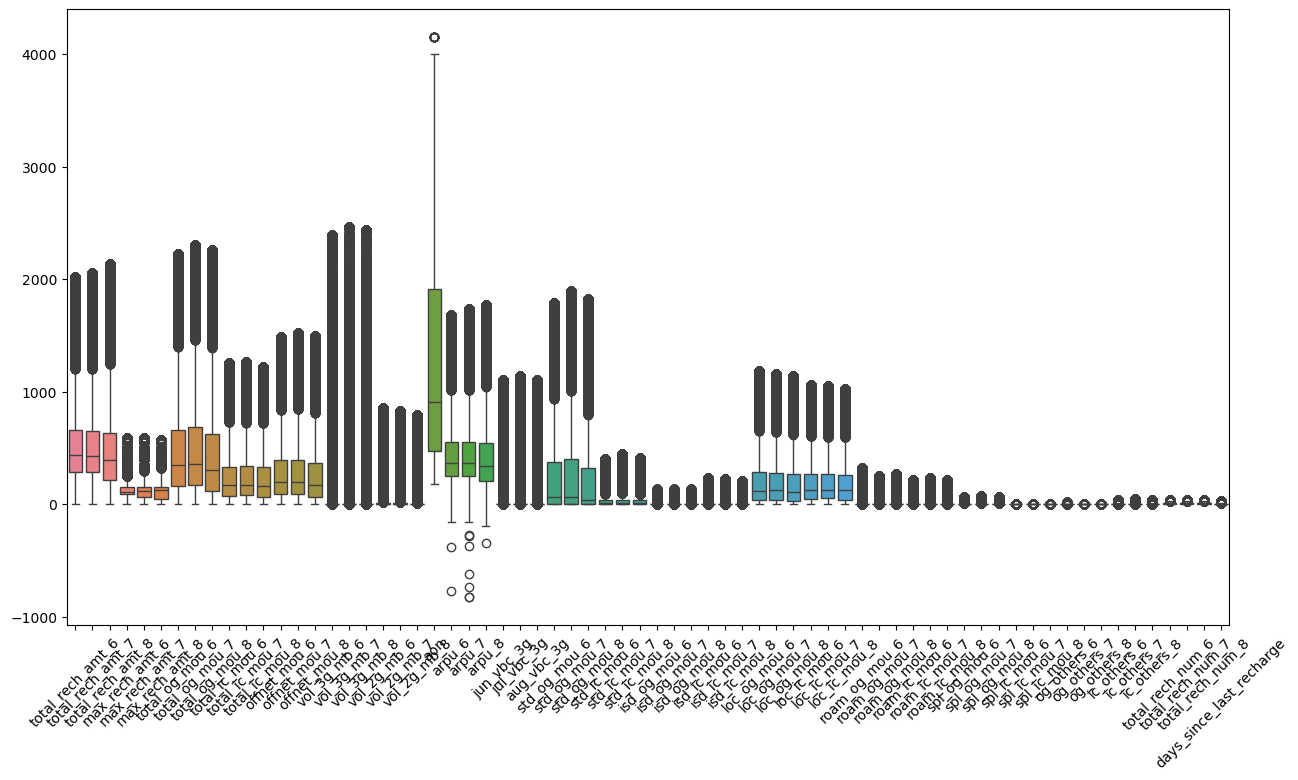

In [2097]:
X_train_filtered1 = X_train_filtered.apply(cap_outliers, axis=0)

plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = X_train_filtered1)

## 4.2 add new feature

In [2098]:
def create_pct_changes(data):
    # Ensure suffixes list has exactly three elements
    if len(suffixes) != 3:
        raise ValueError("Suffixes list must contain exactly three elements.")

    columns = ['total_rech_amt']
    base_cols = ['6', '7', '8']
    
    # Loop over each base column
    for base_col in columns:
        col_1 = f'{base_col}_{suffixes[0]}'
        col_2 = f'{base_col}_{suffixes[1]}'
        col_3 = f'{base_col}_{suffixes[2]}'
        
        pct_change_1_2 = f'{base_col}_pct_change_{suffixes[0]}_{suffixes[1]}'
        pct_change_2_3 = f'{base_col}_pct_change_{suffixes[1]}_{suffixes[2]}'
        
        # Calculate percentage changes
        data[pct_change_1_2] = 100 * ((data[col_2] - data[col_1]) / (data[col_1] + 1e-5))
        data[pct_change_2_3] = 100 * ((data[col_3] - data[col_2]) / (data[col_2] + 1e-5))
    
    return data


In [2099]:
X_train_filtered1 = create_pct_changes(X_train_filtered1)

new_vars = X_train_filtered1.columns

### 4.3 Feature scaling

from chart it is clear we need to scale the data . ferure have different scaling. Lets use Standard scaler (few other alternates are min-max scaling and Z-scaling).

In [2100]:
scale = StandardScaler()
X_train_filtered2 = scale.fit_transform(X_train_filtered1)

<Axes: >

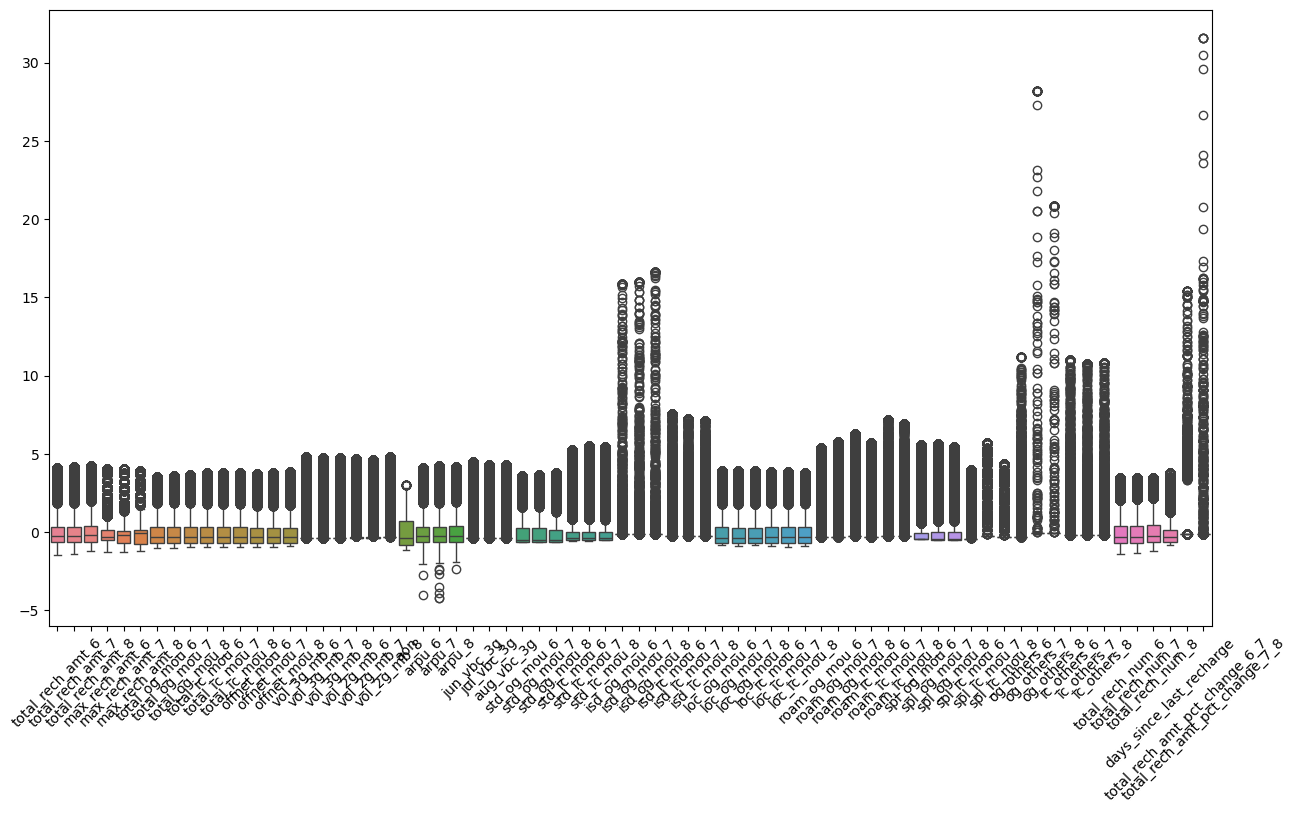

In [2101]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = pd.DataFrame(X_train_filtered2, columns=new_vars))

In [2102]:
X_train_filtered2 = pd.DataFrame(X_train_filtered2, columns=new_vars)

<Axes: >

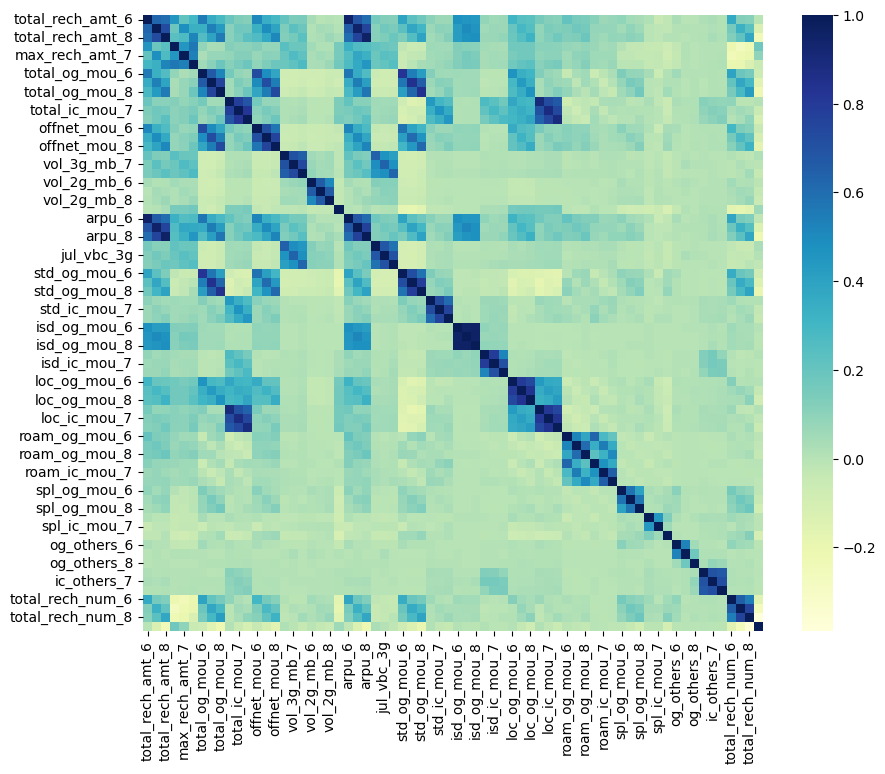

In [2103]:
plt.figure(figsize=(10,8))
sns.heatmap(data.corr(), cmap = 'YlGnBu')

# some fearure are highly correlated we will drop them in feature engineering

<Axes: xlabel='churn_probability', ylabel='Count'>

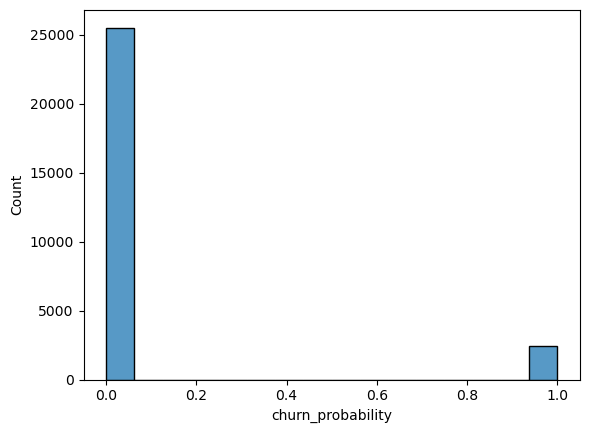

In [2104]:
#Distribution for the churn probability
sns.histplot(y_train)

# 5. Feature engineering and selection

Let's understand feature importances for raw features as well as components to decide top features for modelling.

In [2105]:
## 5.1 Drop highly correlated features > 0.75

In [2106]:
corr_matrix = X_train_filtered2.corr().abs()
# corr_matrix

In [2107]:
threshold = 0.75
corr_pair = []
n = len(corr_matrix.columns)

for i in range(n):
    for j in range(i+1,n ):
        if corr_matrix.iloc[i, j]> threshold:
            col1 = corr_matrix.columns[i]
            col2 = corr_matrix.columns[j]
            corr_value = corr_matrix.iloc[i, j]
            corr_pair.append((col1, col2, round(corr_value, 2)))

In [2108]:
corr_pair, len(set(corr_pair))

([('total_rech_amt_6', 'arpu_6', np.float64(0.94)),
  ('total_rech_amt_7', 'arpu_7', np.float64(0.93)),
  ('total_rech_amt_8', 'arpu_8', np.float64(0.95)),
  ('total_og_mou_6', 'std_og_mou_6', np.float64(0.81)),
  ('total_og_mou_7', 'total_og_mou_8', np.float64(0.76)),
  ('total_og_mou_7', 'std_og_mou_7', np.float64(0.83)),
  ('total_og_mou_8', 'offnet_mou_8', np.float64(0.75)),
  ('total_og_mou_8', 'std_og_mou_8', np.float64(0.83)),
  ('total_ic_mou_6', 'total_ic_mou_7', np.float64(0.8)),
  ('total_ic_mou_6', 'loc_ic_mou_6', np.float64(0.91)),
  ('total_ic_mou_6', 'loc_ic_mou_7', np.float64(0.75)),
  ('total_ic_mou_7', 'total_ic_mou_8', np.float64(0.83)),
  ('total_ic_mou_7', 'loc_ic_mou_7', np.float64(0.9)),
  ('total_ic_mou_7', 'loc_ic_mou_8', np.float64(0.77)),
  ('total_ic_mou_8', 'loc_ic_mou_7', np.float64(0.77)),
  ('total_ic_mou_8', 'loc_ic_mou_8', np.float64(0.91)),
  ('offnet_mou_7', 'offnet_mou_8', np.float64(0.77)),
  ('jun_vbc_3g', 'jul_vbc_3g', np.float64(0.75)),
  ('jul_

In [2109]:
X_train_filtered2 = X_train_filtered2.drop(
['arpu_6', 'arpu_7', 'arpu_8',
'std_og_mou_6','std_og_mou_7','std_og_mou_8',
 'loc_ic_mou_6', 'loc_ic_mou_7','loc_ic_mou_8',
  'loc_og_mou_6', 'loc_og_mou_7','loc_og_mou_8',
 'roam_ic_mou_6',  'roam_ic_mou_7', 'roam_ic_mou_8',
  'roam_og_mou_6',  'roam_og_mou_7', 'roam_og_mou_8',
 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8',
 'jun_vbc_3g', 'jul_vbc_3g', 'aug_vbc_3g'
]
, axis=1)

In [2110]:
new_vars = X_train_filtered2.columns

In [2111]:
len(new_vars)

46

In [2112]:
new_vars

Index(['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8', 'total_og_mou_6',
       'total_og_mou_7', 'total_og_mou_8', 'total_ic_mou_6', 'total_ic_mou_7',
       'total_ic_mou_8', 'vol_3g_mb_6', 'vol_3g_mb_7', 'vol_3g_mb_8',
       'vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8', 'aon', 'std_ic_mou_6',
       'std_ic_mou_7', 'std_ic_mou_8', 'isd_og_mou_6', 'isd_og_mou_7',
       'isd_og_mou_8', 'isd_ic_mou_6', 'isd_ic_mou_7', 'isd_ic_mou_8',
       'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'spl_ic_mou_6',
       'spl_ic_mou_7', 'spl_ic_mou_8', 'og_others_6', 'og_others_7',
       'og_others_8', 'ic_others_6', 'ic_others_7', 'ic_others_8',
       'total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8',
       'days_since_last_recharge', 'total_rech_amt_pct_change_6_7',
       'total_rech_amt_pct_change_7_8'],
      dtype='object')

In [2115]:
new_vars=X_train_filtered2.columns

## Correlation Matrix

<Axes: >

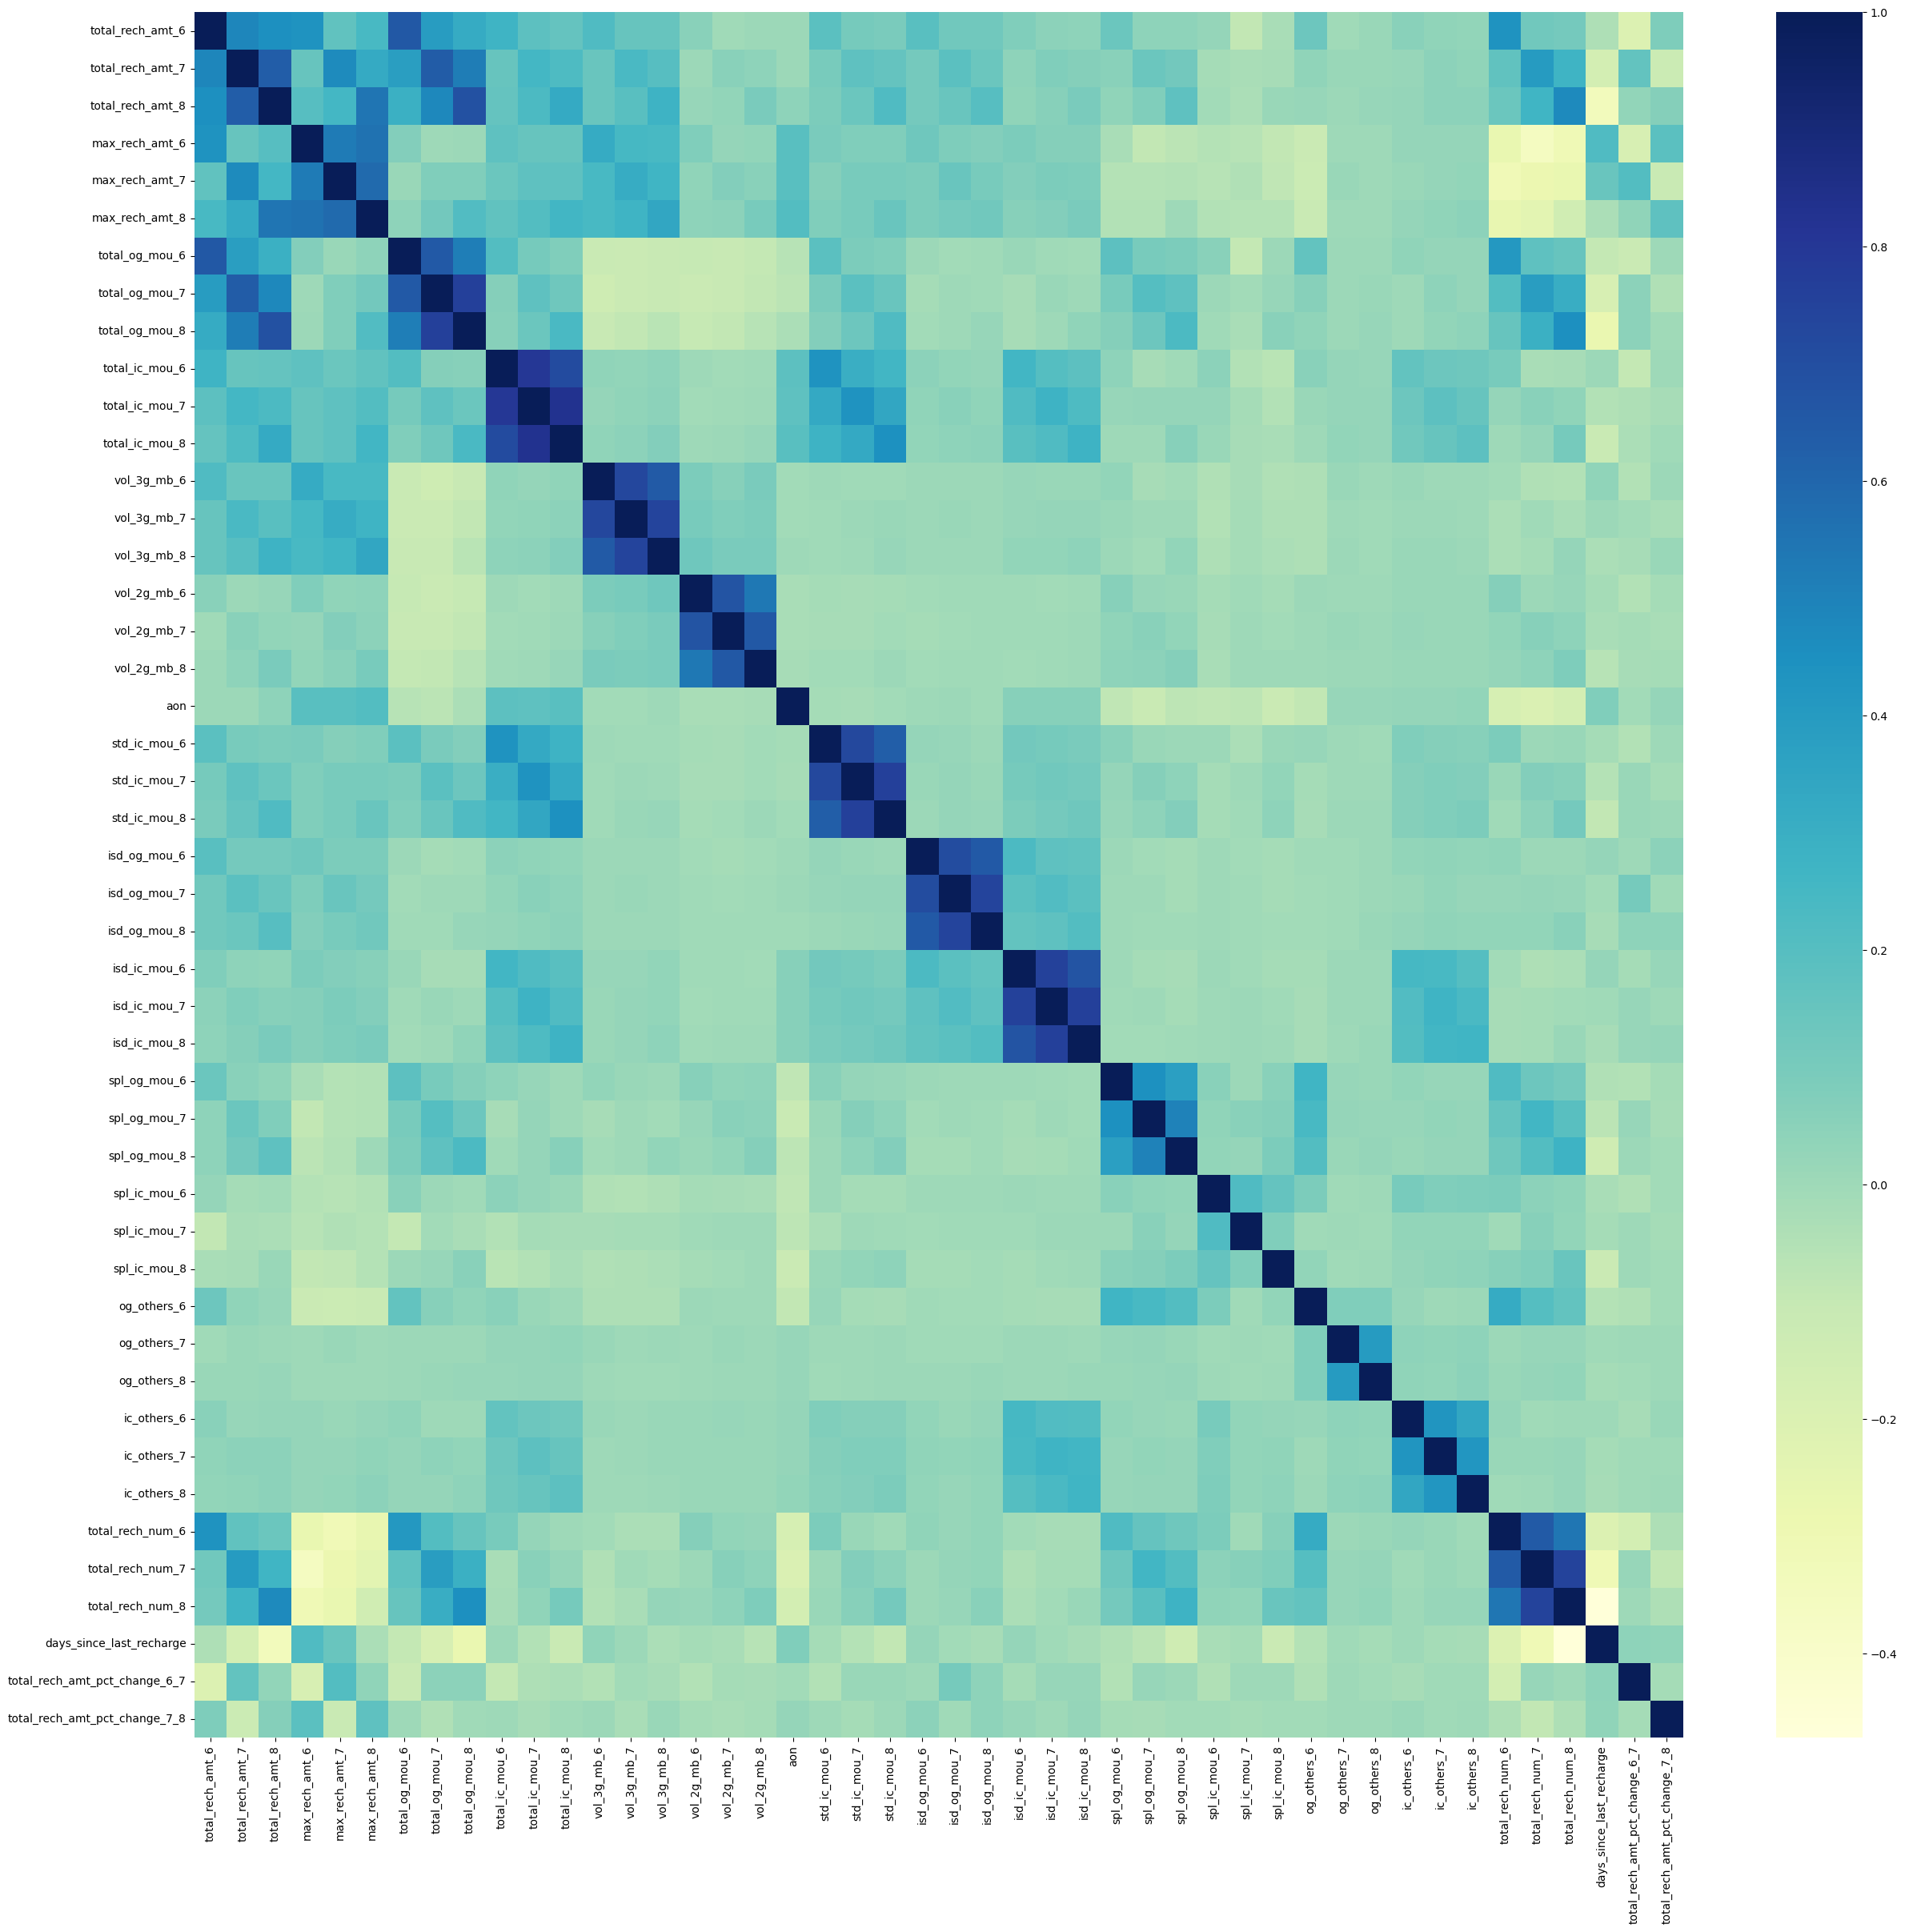

In [2116]:
plt.figure(figsize = (30,28))
sns.heatmap(X_train_filtered2.corr(), cmap='YlGnBu')

 <!-- # Lets understand feature importance -->

<!-- # Feature importance :  
# total_ic_mou_8
# total_og_mou_8
# arpu_8
# roam_og_mou_8
# max_rech_amt_8
# last_day_rch_amt_8
# Recharge Amount
# days_since_last_rechard
# aon -->


#-----------------------------------------------#important features

total_ic_mou_8 , 
total_og_mou_8 ,
total_rech_amt_8 ,
std_ic_mou_8 ,
days_since_last_recharge ,
aon: age on network

In [2121]:
rf = RandomForestClassifier(n_estimators = 100, random_state=110, n_jobs=10)
rf = rf.fit(X_train_filtered2, y_train)

In [2122]:
importance_df = pd.DataFrame( {'value' : rf.feature_importances_*100,
                               'name':list(X_train_filtered2.columns)\
})

importance_df.sort_values(by='value', ascending=False)

,value,name
8,12.418457,total_og_mou_8
11,12.388602,total_ic_mou_8
2,6.868945,total_rech_amt_8
5,4.800666,max_rech_amt_8
21,4.295967,std_ic_mou_8
10,3.712182,total_ic_mou_7
43,3.517801,days_since_last_recharge
18,3.375706,aon
7,3.170060,total_og_mou_7
1,3.007366,total_rech_amt_7


In [2123]:
len(important_features)

33

In [2124]:
#-----------------------------------------------------------------------lets drop feature which are less important

In [2125]:
important_features = importance_df[importance_df['value'] > 0.7]

In [2126]:
important_features['value'].sum()

np.float64(95.68085699555216)

In [2127]:
new_vars = list(important_features['name'])

In [2128]:
X_train_filtered3 = X_train_filtered2[new_vars]

#--------------------------------------------------------------- PCA
 lets use PCA to create new feature


<Axes: >

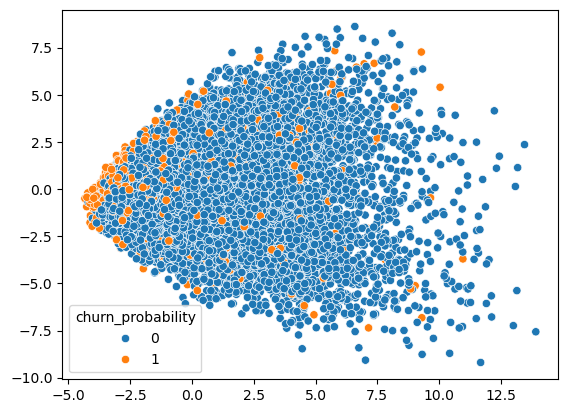

In [2179]:
# Lets try to project the data onto 2D space and plot
pca = PCA()
pca_components = pca.fit_transform(X_train_filtered3)
sns.scatterplot(x=pca_components[:,0], y=pca_components[:,1], hue=y_train)

# 6 - Modelling 

lets create model with logistci regression on 2 PCA componenet

In [2193]:
#-----------------------------------------------------# utility function

In [2197]:
def classication_mertics(y_true,y_pred):
    # Confusion Matrix

    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix")
    print(cm)

    # True Positive, True Negative, False Positive, False Negative

    TP = cm[1,1]
    TN = cm[0,0]
    FP = cm[0,1]
    FN = cm[1,0]

    # Precision

    precision = precision_score(y_true, y_pred)
    print("Precision: ", precision)

    # Recall

    recall = recall_score(y_true, y_pred)
    print("Recall: ", recall)

    # sensitivity, specificity, false positive rate

    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    fpr = FP / (FP + TN)

    print("Sensitivity: ", sensitivity)
    print("Specificity: ", specificity)
    print("False Positive Rate: ", fpr)

    # Accuracy

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    print("Accuracy: ", accuracy)

    # print as a dataframe

    metrics = pd.DataFrame({'Precision': precision, 'Recall': recall, 'Sensitivity': sensitivity, 'Specificity': specificity, 'False Positive Rate': fpr, 'Accuracy': accuracy}, index=[0])
    print(metrics.head())
    return metrics

In [2133]:

outlier_transformer = FunctionTransformer(func=cap_outliers, validate=False)
pct_change_transformer = FunctionTransformer(func=pct_change_transformer, validate=False)


In [2134]:
len(new_vars)

34

In [2136]:
X_train_f = X_train[new_vars]
y_train_f = y_train

X_test_f = X_test[new_vars]
y_test_f = y_test

In [2139]:
X_train_f.describe()

,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_ic_mou_6,...,spl_og_mou_7,spl_og_mou_8,spl_ic_mou_6,og_others_6,ic_others_6,ic_others_7,total_rech_num_6,total_rech_num_7,total_rech_num_8,days_since_last_recharge
count,27983.000000,27983.000000,27983.000000,27983.000000,27983.000000,27983.000000,27983.000000,27983.000000,27983.000000,27983.000000,...,27591.000000,26984.000000,27569.000000,27569.000000,27569.000000,27591.000000,27983.000000,27983.000000,27983.000000,27983.000000
mean,537.393132,532.014830,483.167387,147.084480,149.183111,140.053711,513.471422,528.902703,478.824130,263.071617,...,6.524271,6.215454,0.066265,0.626969,1.056811,1.301574,10.353679,10.310367,8.968945,5.570275
std,494.493285,506.218948,550.537228,146.117698,147.748499,143.251111,568.867014,590.359085,593.092666,329.482871,...,22.473852,20.052563,0.193086,6.359595,13.655323,15.472806,8.282998,8.487457,8.477689,8.297566
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,290.000000,286.000000,217.000000,90.000000,67.500000,50.000000,164.625000,169.470000,116.390000,71.010000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,5.000000,4.000000,1.000000
50%,436.000000,428.000000,390.000000,110.000000,120.000000,130.000000,345.980000,353.480000,303.930000,169.660000,...,0.330000,0.360000,0.000000,0.000000,0.000000,0.000000,8.000000,8.000000,7.000000,3.000000
75%,656.000000,653.000000,630.000000,154.000000,154.000000,154.000000,659.175000,685.500000,626.530000,334.205000,...,5.780000,5.660000,0.000000,0.000000,0.030000,0.000000,13.000000,13.000000,12.000000,6.000000
max,35190.000000,40335.000000,45320.000000,3559.000000,3299.000000,3399.000000,10674.030000,8285.640000,14043.060000,7716.140000,...,1265.790000,954.510000,19.760000,800.890000,1344.140000,1495.940000,125.000000,138.000000,127.000000,85.000000


In [2140]:
X_train_f.shape, X_test_f.shape, y_train_f.shape, y_test_f.shape

((27983, 34), (6996, 34), (27983,), (6996,))

#-----------------------------------------------------------------------------# logistic regression

In [2147]:
imp = KNNImputer(n_neighbors=10)
scale = StandardScaler()
# smote = SMOTE(random_state=110)
pca = PCA(0.95) # modify to variance .95
lr = LogisticRegression(max_iter=100)

In [2148]:
pipe_lr = Pipeline([
    ('imputation', imp),
    ('outlier', outlier_transformer),
    ('scaling', scale),
    # ('smote', smote),
    ('pca', pca),
    ('model', lr)
])


In [2149]:
pipe_lr.fit(X_train_f, y_train_f)

Pipeline(steps=[('imputation', KNNImputer(n_neighbors=10)),
                ('outlier',
                 FunctionTransformer(func=<function cap_outliers at 0x3b2863a60>)),
                ('scaling', StandardScaler()), ('pca', PCA(n_components=0.95)),
                ('model', LogisticRegression())])

In [2150]:
# 89 on 22 columns
train_score = pipe_lr.score(X_train_f, y_train_f)
print("Training accuracy:", train_score)

Training accuracy: 0.9213808383661509


In [2151]:
test_score = pipe_lr.score(X_test_f, y_test_f)
print("Test accuracy:", test_score)

Test accuracy: 0.9186678101772442


In [2199]:
classication_mertics(y_test_f , pipe_lr.predict(X_test_f))

Confusion Matrix
[[6261   87]
 [ 482  166]]
Precision:  0.6561264822134387
Recall:  0.25617283950617287
Sensitivity:  0.25617283950617287
Specificity:  0.9862948960302458
False Positive Rate:  0.013705103969754254
Accuracy:  0.9186678101772442
   Precision    Recall  Sensitivity  Specificity  False Positive Rate  \
0   0.656126  0.256173     0.256173     0.986295             0.013705   

   Accuracy  
0  0.918668  


,Precision,Recall,Sensitivity,Specificity,False Positive Rate,Accuracy
0,0.656126,0.256173,0.256173,0.986295,0.013705,0.918668


In [2152]:
#-----------------------------------------------------------------------------# random forest

In [2165]:
rf = RandomForestClassifier(random_state=110, n_jobs=10, n_estimators=200, max_depth = 4 )
pipe_rf = Pipeline([
    ('imputation', imp),
    ('outlier', outlier_transformer),
    ('scaling', scale),
    # ('smote', smote),
    ('pca', pca),
    ('model', rf)
])


In [2166]:
pipe_rf.fit(X_train_f, y_train_f )

Pipeline(steps=[('imputation', KNNImputer(n_neighbors=10)),
                ('outlier',
                 FunctionTransformer(func=<function cap_outliers at 0x3b2863a60>)),
                ('scaling', StandardScaler()), ('pca', PCA(n_components=0.95)),
                ('model',
                 RandomForestClassifier(max_depth=4, n_estimators=200,
                                        n_jobs=10, random_state=110))])

In [2167]:
train_score = pipe_rf.score(X_train_f, y_train_f)
print("Training accuracy:", train_score)

Training accuracy: 0.9156630811564164


In [2168]:
test_score = pipe_rf.score(X_test_f, y_test_f)
print("Test accuracy:", test_score)

Test accuracy: 0.9116638078902229


#-----------------------------------------------------------------------------# XGBoost

In [2169]:
xgb = XGBClassifier(random_state=110, n_jobs=10, max_depth=4)

pipe_xgb = Pipeline([
    ('imputation', imp),
    ('outlier', outlier_transformer),
    ('scaling', scale),
    # ('smote', smote),
    ('pca', pca),
    ('model', xgb)
])


In [2170]:
pipe_xgb.fit(X_train_f, y_train_f)

Pipeline(steps=[('imputation', KNNImputer(n_neighbors=10)),
                ('outlier',
                 FunctionTransformer(func=<function cap_outliers at 0x3b2863a60>)),
                ('scaling', StandardScaler()), ('pca', PCA(n_components=0.95)),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stoppi...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=10,
                               num_parallel_tree=None, random_state=110, ...))])

In [2171]:
train_score = pipe_xgb.score(X_train_f, y_train_f)
print("Training accuracy:", train_score)

Training accuracy: 0.9534360147232248


In [2172]:
test_score = pipe_xgb.score(X_test_f, y_test_f)
print("Test accuracy:", test_score)

Test accuracy: 0.9220983419096627


-----------------------------------------------------LR Pred

# HyperParameter Tuning


In [2173]:
pca = PCA(0.95)

----------------------------------------------------------------XGB

In [2174]:
xgb_t = XGBClassifier(random_state=110, n_jobs=10)

pipe_xgb_t = Pipeline([
    ('imputation', imp),
    ('outlier', outlier_transformer),
    ('scaling', scale),
    # ('smote', smote),
    ('pca', pca),
    ('model', xgb_t)
])
## Define parameters
param_grid_xgb_t = {
'model__max_depth':[3,4,5],
'model__learning_rate' : [0.01, 0.05, 0.1],
'model__min_child_weight': [1, 2, 3],
'model__colsample_bytree': [0.6, 0.8], 
'model__gamma':[0.5, 1, 5],
'model__reg_lambda':[5, 10, 15],
'model__reg_alpha':[0.1, 0.5, 1, 5],
'model__subsample':[0.5, 0.7, 0.8]
}
# Stratified
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [2175]:
random_search_xgb_t = RandomizedSearchCV(estimator=pipe_xgb_t, param_distributions=param_grid_xgb_t,
    n_iter=20,  # Number of parameter settings sampled
    scoring='accuracy', 
    cv=stratified_kfold, 
    verbose=2,  
    n_jobs=-1,  
    random_state=110 
)
# Fit the RandomizedSearchCV to the data
random_search_xgb_t.fit(X_train_f, y_train_f)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('imputation',
                                              KNNImputer(n_neighbors=10)),
                                             ('outlier',
                                              FunctionTransformer(func=<function cap_outliers at 0x3b2863a60>)),
                                             ('scaling', StandardScaler()),
                                             ('pca', PCA(n_components=0.95)),
                                             ('model',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            co...
                                                            random_state=110, ...))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'model__colsample_bytree': [0.6, 0.8],
                                        'model__gamma': [0.5, 1, 5],
                                        'model__learning_rate': [0.01, 0.05,
                                                                 0.1],
                                        'model__max_depth': [3, 4, 5],
                                        'model__min_child_weight': [1, 2, 3],
                                        'model__reg_alpha': [0.1, 0.5, 1, 5],
                                        'model__reg_lambda': [5, 10, 15],
                                        'model__subsample': [0.5, 0.7, 0.8]},
                   random_state=110, scoring='accuracy', verbose=2)

In [2176]:
random_search_xgb_t.best_params_

{'model__subsample': 0.5,
 'model__reg_lambda': 10,
 'model__reg_alpha': 0.1,
 'model__min_child_weight': 2,
 'model__max_depth': 4,
 'model__learning_rate': 0.1,
 'model__gamma': 1,
 'model__colsample_bytree': 0.6}

In [2177]:
xgb_t_model = random_search_xgb_t.best_estimator_
y_pred = xgb_t_model.predict(X_train_f)
print(accuracy_score(y_train_f, y_pred))

0.935246399599757


In [2028]:
# xgb_t_model = random_search_xgb_t.best_estimator_
y_pred_t = xgb_t_model.predict(X_test_f)
print(accuracy_score(y_test_f, y_pred_t))

0.9226700971983991


----------------------------------------------------------------Random Forest

In [2180]:
rf_t = RandomForestClassifier(random_state=110, n_jobs=10)
pipe_rf_t = Pipeline([
    ('imputation', imp),
    ('outlier', outlier_transformer),
    ('scaling', scale),
    # ('smote', smote),
    ('pca', pca),
    ('model', rf_t)
])

param_grid_rf_t = {
'model__n_estimators':[100,150,200],
'model__max_depth':[3,5,7],
'model__min_samples_split':[10,20,30,40],
'model__max_leaf_nodes':[20,40,60]
}

In [2181]:
# Initialize RandomizedSearchCV with StratifiedKFold
random_search_rf_t = RandomizedSearchCV(estimator=pipe_rf_t, param_distributions=param_grid_rf_t,
    n_iter=20,  # Number of parameter settings sampled
    scoring='accuracy',  # Scoring metric
    cv=stratified_kfold,  # Use StratifiedKFold
    verbose=2,  # Verbosity level
    n_jobs=-1,  # Use all available CPU cores
    random_state=110  # Seed for reproducibility
)
# Fit the RandomizedSearchCV to the data
random_search_rf_t.fit(X_train_f, y_train_f)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('imputation',
                                              KNNImputer(n_neighbors=10)),
                                             ('outlier',
                                              FunctionTransformer(func=<function cap_outliers at 0x3b2863a60>)),
                                             ('scaling', StandardScaler()),
                                             ('pca', PCA()),
                                             ('model',
                                              RandomForestClassifier(n_jobs=10,
                                                                     random_state=110))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'model__max_depth': [3, 5, 7],
                                        'model__max_leaf_nodes': [20, 40, 60],
                                        'model__min_samples_split': [10, 20, 30,
                                                                     40],
                                        'model__n_estimators': [100, 150, 200]},
                   random_state=110, scoring='accuracy', verbose=2)

In [2182]:
X_train_f.shape, X_test_f.shape

((27983, 34), (6996, 34))

In [2183]:
rf_t_model = random_search_rf_t.best_estimator_
y_pred = rf_t_model.predict(X_train_f)
print(accuracy_score(y_train_f, y_pred))

0.9210949505056641


In [2184]:
# best_model = random_search_rf_t.best_estimator_
y_pred_t = rf_t_model.predict(X_test_f)
print(accuracy_score(y_test_f, y_pred_t))

0.9146655231560892


# 7. Creating submission file

Sample output file will contain custmer_id, prediction

In [2185]:
# load test file
unseen_data = pd.read_csv('./kaggle/input/test.csv')
unseen_data.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0,69999,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,91.882,65.330,...,0,0,0,NaN,NaN,NaN,1692,0.00,0.00,0.00
1,70000,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,414.168,515.568,...,0,0,0,NaN,NaN,NaN,2533,0.00,0.00,0.00
2,70001,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,329.844,434.884,...,0,0,0,NaN,NaN,NaN,277,525.61,758.41,241.84
3,70002,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,43.550,171.390,...,0,0,0,NaN,NaN,NaN,1244,0.00,0.00,0.00
4,70003,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,306.854,406.289,...,0,0,0,NaN,NaN,NaN,462,0.00,0.00,0.00


In [2186]:
submission_data = unseen_data.set_index('id')

In [2187]:
submission_data =days_since_last_recharge(submission_data)

In [2188]:
cols = new_vars
submission_data = submission_data[cols]
submission_data.shape

(30000, 34)

In [2189]:
pipe_final = xgb_t_model

In [2190]:
unseen_data['churn_probability'] = pipe_final.predict(submission_data)
unseen_data.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,69999,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,91.882,65.330,...,0,0,NaN,NaN,NaN,1692,0.00,0.00,0.00,0
1,70000,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,414.168,515.568,...,0,0,NaN,NaN,NaN,2533,0.00,0.00,0.00,0
2,70001,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,329.844,434.884,...,0,0,NaN,NaN,NaN,277,525.61,758.41,241.84,0
3,70002,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,43.550,171.390,...,0,0,NaN,NaN,NaN,1244,0.00,0.00,0.00,0
4,70003,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,306.854,406.289,...,0,0,NaN,NaN,NaN,462,0.00,0.00,0.00,0


In [2191]:
output = unseen_data[['id','churn_probability']]
output.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,0
3,70002,0
4,70003,0


In [2192]:
output.to_csv('./kaggle/output/submission_telecom_churn.csv', index=False)

[CV] END model__colsample_bytree=0.6, model__gamma=5, model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=1, model__reg_alpha=0.5, model__reg_lambda=15, model__subsample=0.7; total time=  13.0s
[CV] END model__colsample_bytree=0.6, model__gamma=1, model__learning_rate=0.01, model__max_depth=5, model__min_child_weight=3, model__reg_alpha=5, model__reg_lambda=15, model__subsample=0.8; total time=   9.0s
[CV] END model__colsample_bytree=0.8, model__gamma=0.5, model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=1, model__reg_alpha=5, model__reg_lambda=5, model__subsample=0.7; total time=   6.7s
[CV] END model__colsample_bytree=0.6, model__gamma=5, model__learning_rate=0.05, model__max_depth=3, model__min_child_weight=1, model__reg_alpha=5, model__reg_lambda=10, model__subsample=0.7; total time=   7.5s
[CV] END model__colsample_bytree=0.6, model__gamma=5, model__learning_rate=0.1, model__max_depth=4, model__min_child_weight=3, model__reg_alpha=1, model_